<a href="https://colab.research.google.com/github/phucb2/paddy_disease_classification/blob/main/paddy_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [2]:
# you can get this file from your kaggle account page
from google.colab import userdata

user = userdata.get('KAGGLE_USER')
pwd = userdata.get('KAGGLE_PASS')

import os
# Make root directory
os.makedirs('/root/.kaggle', exist_ok=True)

with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write(f'{{"username":"{user}","key":"{pwd}"}}')

# Change chmod
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
comp = 'paddy-disease-classification'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|██████████| 1.02G/1.02G [00:58<00:00, 18.7MB/s]


In [4]:
!pip install -Uqq "timm>=0.6.2.dev0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.1 MB/s eta 0:00:00


In [5]:
import torch
import numpy as np

import timm # make sure import this first
from fastai.vision.all import *
set_seed(42)

In [6]:
path

Path('paddy-disease-classification')

In [7]:
path.ls()

(#4) [Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/sample_submission.csv')]

In [8]:
!ls {path}

sample_submission.csv  test_images  train.csv  train_images


In [9]:
!head {path/'train.csv'}

image_id,label,variety,age
100330.jpg,bacterial_leaf_blight,ADT45,45
100365.jpg,bacterial_leaf_blight,ADT45,45
100382.jpg,bacterial_leaf_blight,ADT45,45
100632.jpg,bacterial_leaf_blight,ADT45,45
101918.jpg,bacterial_leaf_blight,ADT45,45
102353.jpg,bacterial_leaf_blight,ADT45,45
102848.jpg,bacterial_leaf_blight,ADT45,45
103051.jpg,bacterial_leaf_blight,ADT45,45
103702.jpg,bacterial_leaf_blight,ADT45,45


Two thing should consider
1. Creating good validation set
2. Iterating rapidly to improve validation

# Parameters

In [10]:
IMAGE_SIZE = 224
VALID_PCT = 0.2


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Looking at the data (EDA)

In [11]:
df = pd.read_csv(path/'train.csv')
df.head()

image_id                  label variety  age
0  100330.jpg  bacterial_leaf_blight   ADT45   45
1  100365.jpg  bacterial_leaf_blight   ADT45   45
2  100382.jpg  bacterial_leaf_blight   ADT45   45
3  100632.jpg  bacterial_leaf_blight   ADT45   45
4  101918.jpg  bacterial_leaf_blight   ADT45   45

Number of images in train set: 10407
Number of labels in train set: 10


<Axes: >

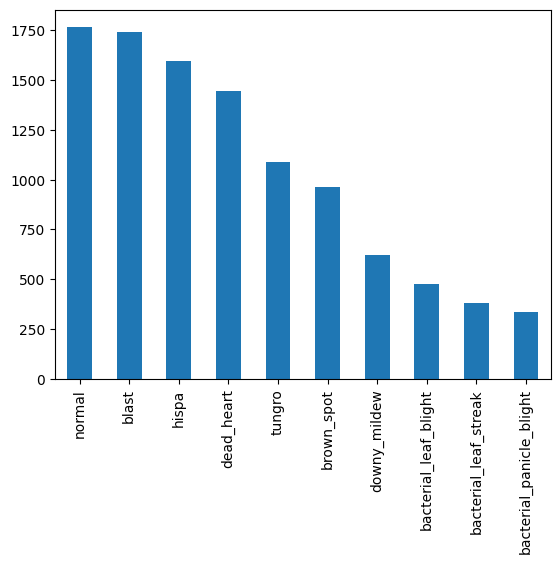

In [12]:
print("Number of images in train set:", len(df))
print("Number of labels in train set:", len(df['label'].unique()))
df['label'].value_counts().plot.bar()

In [13]:
# load some training images
files = get_image_files(path/'train_images')
files[:5]

(#5) [Path('paddy-disease-classification/train_images/normal/100530.jpg'),Path('paddy-disease-classification/train_images/normal/110249.jpg'),Path('paddy-disease-classification/train_images/normal/100549.jpg'),Path('paddy-disease-classification/train_images/normal/102887.jpg'),Path('paddy-disease-classification/train_images/normal/103286.jpg')]

<Axes: >

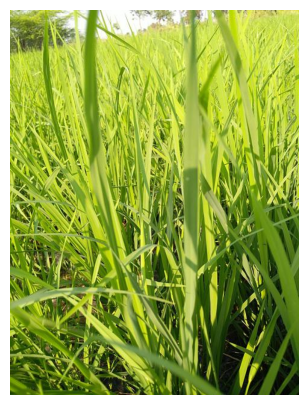

In [14]:
# show some images
img = PILImage.create(files[0])
img.show()

In [15]:
# Display a grid of image
def show_images(files, n=4, figsize=(12,8)):
    fig, axes = plt.subplots(figsize=figsize, nrows=n, ncols=n)
    for i,ax in enumerate(axes.flatten()):
        img = PILImage.create(files[i])
        img.show(ax=ax)
    plt.tight_layout()

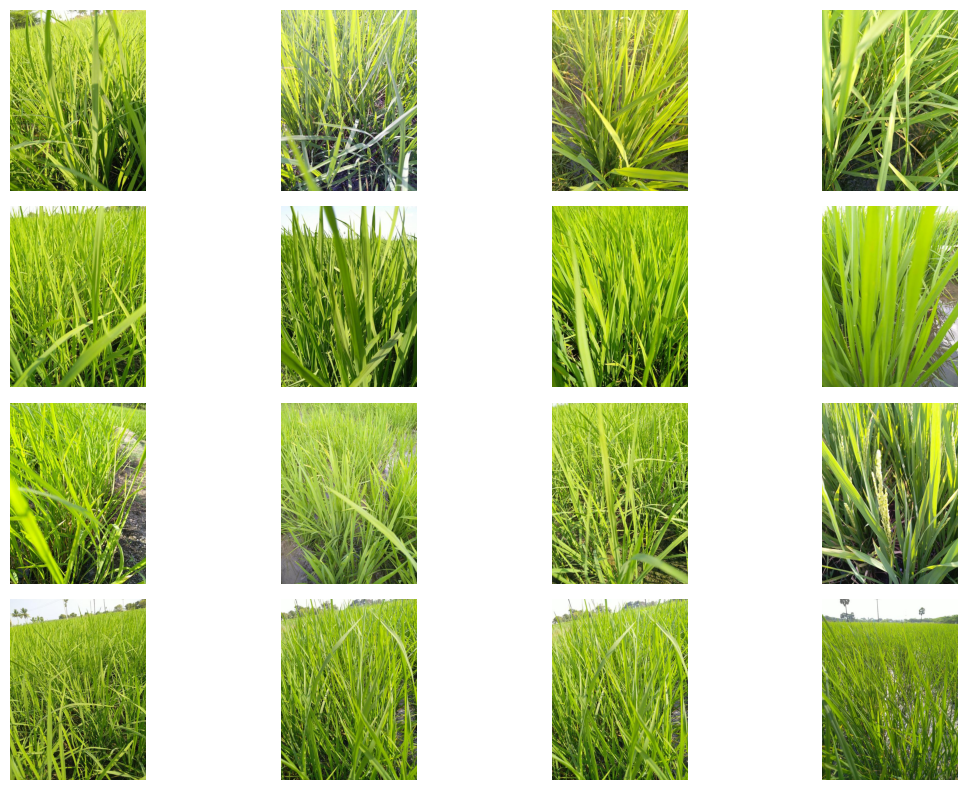

In [16]:
show_images(files)

In [17]:
from fastcore.parallel import *
def get_size(fn):
    img = PILImage.create(fn)
    return img.shape

# get image sizes
img_sizes = parallel(get_size, files, n_workers=4)
img_sizes[:5]

(#5) [(640, 480),(640, 480),(640, 480),(640, 480),(640, 480)]

In [18]:
pd.Series(img_sizes).value_counts()

(640, 480)    10403
(480, 640)        4
dtype: int64

In [19]:
640 / 480

1.3333333333333333

In [20]:
# check test set image size
test_files = get_image_files(path/'test_images')
test_img_sizes = parallel(get_size, test_files, n_workers=4)
pd.Series(test_img_sizes).value_counts()

(640, 480)    3467
(480, 640)       2
dtype: int64

In [21]:
# create dataframe for image sizes, and filenames
df_sizes = pd.DataFrame({'file': files, 'size': img_sizes})
df_sizes.head()

file        size
0  paddy-disease-classification/train_images/normal/100530.jpg  (640, 480)
1  paddy-disease-classification/train_images/normal/110249.jpg  (640, 480)
2  paddy-disease-classification/train_images/normal/100549.jpg  (640, 480)
3  paddy-disease-classification/train_images/normal/102887.jpg  (640, 480)
4  paddy-disease-classification/train_images/normal/103286.jpg  (640, 480)

In [22]:
# get abnormal image sizes
abnormal_sizes = df_sizes['size'].value_counts().index[1:]
# get abnormal image files
abnormal_files = df_sizes[df_sizes['size'].isin(abnormal_sizes)]['file'].values

In [23]:
abnormal_files

array([Path('paddy-disease-classification/train_images/brown_spot/103343.jpg'),
       Path('paddy-disease-classification/train_images/brown_spot/103050.jpg'),
       Path('paddy-disease-classification/train_images/bacterial_leaf_blight/103734.jpg'),
       Path('paddy-disease-classification/train_images/bacterial_leaf_blight/100622.jpg')],
      dtype=object)

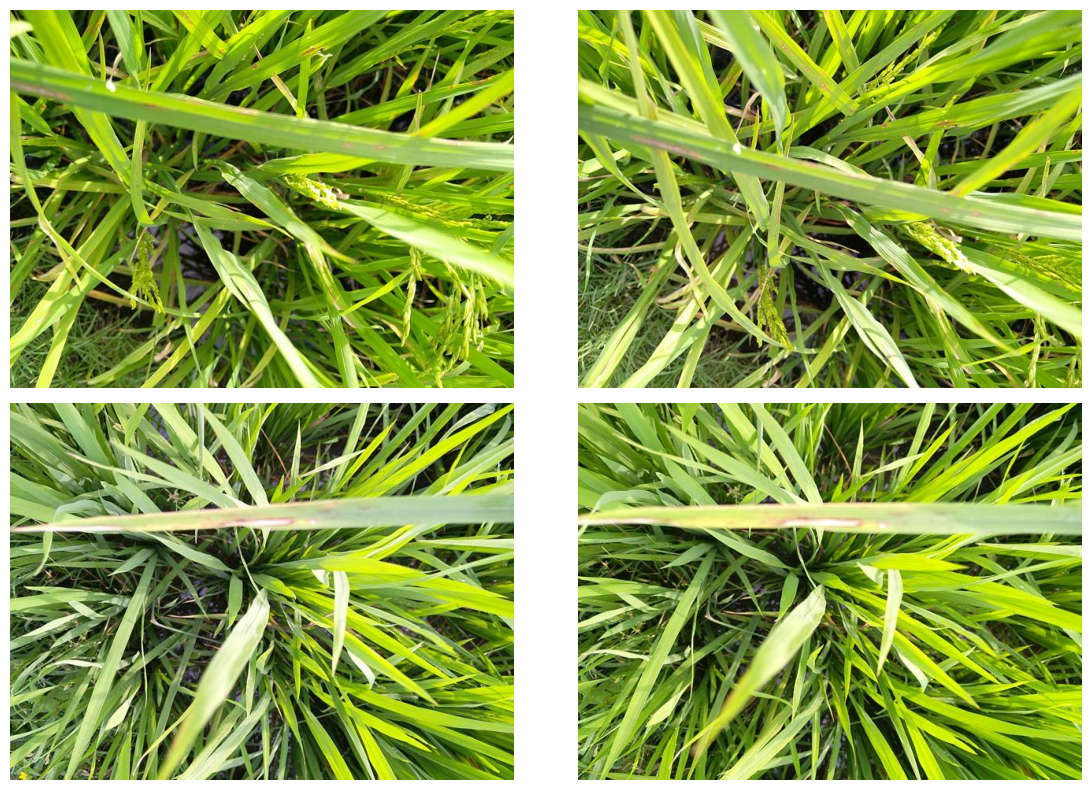

In [24]:
# Show abnormal images
show_images(abnormal_files, n=2)

# Data loader

In [25]:
train_path = path/'train_images'
train_path

Path('paddy-disease-classification/train_images')

In [26]:

dls = ImageDataLoaders.from_folder(
    train_path,
    valid_pct=VALID_PCT, seed=42,
    # use image size from dataframe
    item_tfms=Resize(IMAGE_SIZE),
    device=device,
    # use image augmentations
    batch_tfms=aug_transforms(size=IMAGE_SIZE, min_scale=0.75)
)

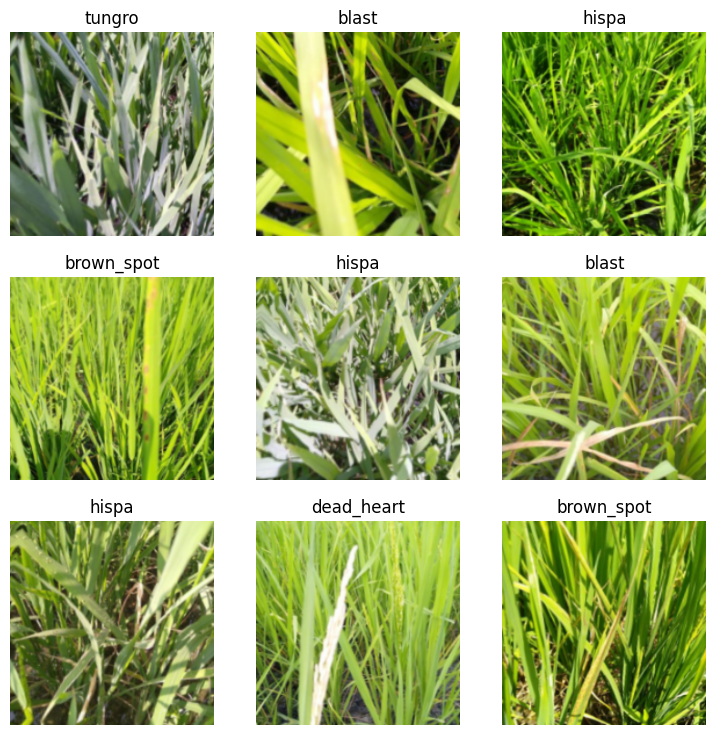

In [27]:
# show some images
dls.show_batch()

# Training

## ResNet18
Now start with simple (or quick neural network)

In [28]:
# create learner
learn = vision_learner(dls, 'resnet18', metrics=error_rate, path='.') #.to_fp16()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0010000000474974513)

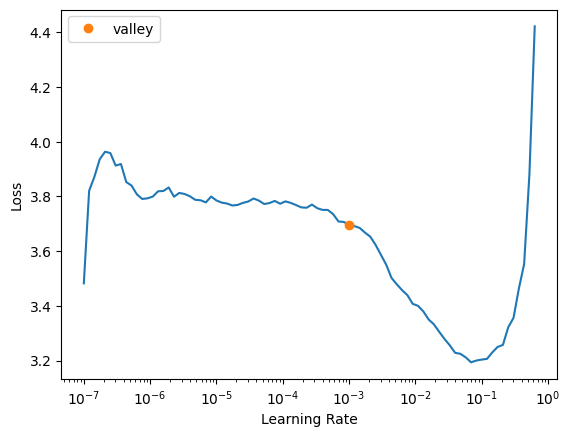

In [29]:
learn.lr_find()

In [30]:
learn.fit_one_cycle(10, 1e-2)

In [31]:
# create test dataloader
test_files = get_image_files(path/'test_images').sorted()
test_dl = dls.test_dl(test_files, with_labels=False)
# get predictions
probs, _, idxs = learn.get_preds(dl=test_dl, with_decoded=True)

mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0              hispa
1             normal
2       downy_mildew
3              blast
4              blast
            ...     
3464      dead_heart
3465           hispa
3466          normal
3467    downy_mildew
3468      dead_heart
Name: idxs, Length: 3469, dtype: object

In [32]:
test_files[:5]

(#5) [Path('paddy-disease-classification/test_images/200001.jpg'),Path('paddy-disease-classification/test_images/200002.jpg'),Path('paddy-disease-classification/test_images/200003.jpg'),Path('paddy-disease-classification/test_images/200004.jpg'),Path('paddy-disease-classification/test_images/200005.jpg')]

In [33]:
# create submission dataframe
sub = pd.read_csv(path/'sample_submission.csv')
sub['label'] = results

In [34]:
sub.head()

image_id         label
0  200001.jpg         hispa
1  200002.jpg        normal
2  200003.jpg  downy_mildew
3  200004.jpg         blast
4  200005.jpg         blast

In [35]:
sub.to_csv('submission.csv', index=False)

In [36]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('submission.csv', 'initial rn26d 128px', comp)

100%|██████████| 70.4k/70.4k [00:01<00:00, 43.0kB/s]


## Convnet model

> Resize image first
> Let's do resizing images

In [37]:
# Use resize_images method to resize images
src = path
dest = Path('./paddy-disease-classification-resized/')

resize_images(src, dest=dest, max_size=224, max_workers=4, recurse=True)

In [38]:
avail_pretrained_models = timm.list_models(pretrained=True)
len(avail_pretrained_models), avail_pretrained_models[:5]

(1298,
 ['bat_resnext26ts.ch_in1k',
  'beit_base_patch16_224.in22k_ft_in22k',
  'beit_base_patch16_224.in22k_ft_in22k_in1k',
  'beit_base_patch16_384.in22k_ft_in22k_in1k',
  'beit_large_patch16_224.in22k_ft_in22k'])

In [39]:
train_path = dest / 'train_images'
dls = ImageDataLoaders.from_folder(
    train_path,
    valid_pct=VALID_PCT,
    seed=42,
    # use image size from dataframe
    item_tfms=Resize(IMAGE_SIZE),
    device=device,
    # use image augmentations
    batch_tfms=aug_transforms(size=IMAGE_SIZE, min_scale=0.75)
)

learn = vision_learner(dls, 'convnext_small', metrics=error_rate, path='.').to_fp16()
learn.fit_one_cycle(10, 1e-2)

model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
train_path = dest / 'train_images'
dls = ImageDataLoaders.from_folder(
    train_path,
    valid_pct=VALID_PCT,
    seed=42,
    # use image size from dataframe
    item_tfms=Resize(IMAGE_SIZE),
    device=device,
    # use image augmentations
    batch_tfms=aug_transforms(size=IMAGE_SIZE, min_scale=0.75)
)

learn = vision_learner(dls, 'convnext_small', metrics=error_rate, path='.').to_fp16()
learn.fine_tune(10, 1e-2)

In [ ]:
train_path = dest / 'train_images'


dls = ImageDataLoaders.from_folder(
    train_path,
    valid_pct=VALID_PCT,
    seed=42,
    # use image size from dataframe
    item_tfms=Resize(IMAGE_SIZE),
    device=device,
    # use image augmentations
    batch_tfms=aug_transforms(size=IMAGE_SIZE, min_scale=0.75)
)

learn = vision_learner(dls, 'convnext_small', metrics=error_rate, path='.').to_fp16()
learn.fine_tune(10, 1e-2)

In [ ]:
def generate_preds():
  # create test dataloader
  test_files = get_image_files(path/'test_images').sorted()
  test_dl = dls.test_dl(test_files, with_labels=False)
  # get predictions
  probs, _, idxs = learn.get_preds(dl=test_dl, with_decoded=True)

  mapping = dict(enumerate(dls.vocab))
  results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
  # create submission dataframe
  sub = pd.read_csv(path/'sample_submission.csv')
  sub['label'] = results
  print("Generating ... submission.csv")
  sub.to_csv('submission.csv', index=False)

In [ ]:
generate_preds()

In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('submission.csv', 'initial convnext_small  320x240px', comp)

In [ ]:

dls = ImageDataLoaders.from_folder(
    train_path,
    valid_pct=VALID_PCT, seed=42,
    # use image size from dataframe
    item_tfms=Resize(320,240),
    device=device,
    # use image augmentations
    batch_tfms=aug_transforms(size=(320,240), min_scale=0.75)
)

In [ ]:
learn = vision_learner(dls, 'convnext_large_in22k', metrics=error_rate, path='.').to_fp16()
learn.fine_tune(10, 1e-2)

In [ ]:
dls.show_batch()

In [ ]:
4:3

In [ ]:
240/3*4

# Resize images

In [41]:
# Use resize_images method to resize images
src = path
dest = Path('./paddy-disease-classification-resized/')

resize_images(src, dest=dest, max_size=224, max_workers=4, recurse=True)

In [59]:
def train_model(arch,
                item_tfms,
                batch_tfms = aug_transforms(),
                path = dest,
                enable_mixup = True,
                dry_run=False):
    dls = ImageDataLoaders.from_folder(
        path,
        valid_pct=VALID_PCT, seed=42,
        # use image size from dataframe
        item_tfms=item_tfms,
        device=device,
        # use image augmentations
        batch_tfms=batch_tfms
    )
    learn = vision_learner(dls, arch, metrics=error_rate, path='.')
    if enable_mixup:
        learn = learn.to_fp16()
    if dry_run:
        print("Dry run, skipping training")
        learn.fit_one_cycle(1, 1e-2, cbs=ShortEpochCallback(pct=0.01, short_valid=True))
    else:
        learn.fine_tune(10, 1e-2)
    return learn

In [65]:
 dest / 'train_images'

Path('paddy-disease-classification-resized/train_images')

In [63]:
path

Path('paddy-disease-classification')

In [71]:
Resize??

In [72]:
learner = train_model('convnext_small',
                      Resize(320,240),
                      aug_transforms(size=(320,240), min_scale=0.75),
                      dest / 'train_images',
                      enable_mixup = False)

OutOfMemoryError: CUDA out of memory. Tried to allocate 114.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 55.06 MiB is free. Process 2426 has 14.69 GiB memory in use. Of the allocated memory 13.47 GiB is allocated by PyTorch, and 1.03 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [68]:
learner.export(fname='export.pkl')

In [69]:
# get validation set predictions
valid_dls = learner.dls.valid
probs, targs, idxs = learner.get_preds(dl=valid_dls, with_decoded=True)

# get error rate
error_rate(probs, targs)

TensorBase(0.0336)

In [70]:
probs, targs = learner.tta(dl=valid_dls)
error_rate(probs, targs)

TensorBase(0.0308)

In [ ]:
learner = train_model('convnext_small',
                      Resize(IMAGE_SIZE,IMAGE_SIZE),
                      aug_transforms(size=(IMAGE_SIZE,IMAGE_SIZE), min_scale=0.75),
                      dest / 'train_images')